# Goal

The goal of this notebook is to determine if a Gaussian distribution (and with which range) is a valid approximation for the points scored by a NBA player in a game. We will take Stephen Curry (superstar), Monte Morris (bench player) and Isaac Bonga (end of bench player).

In [1]:
import pandas as pd
from nba_api.stats.endpoints import playercareerstats, commonplayerinfo, playerprofilev2
from nba_api.stats.static import players
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder, boxscorescoringv2, boxscoretraditionalv2
from alive_progress import alive_bar
import numpy as np
import seaborn as sns
import matplotlib.mlab as mlab
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.api as sm
from scipy.special import expit
from scipy.interpolate import interp1d
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#!pip install scipy
#!pip install statsmodels

In [3]:
# ToDo - add explanation as to why qq-plots are a good indicator of gaussian distributions.
# https://www.graphpad.com/support/faq/testing-data-for-normal-distrbution/
# https://towardsdatascience.com/6-ways-to-test-for-a-normal-distribution-which-one-to-use-9dcf47d8fa93
# https://statsandr.com/blog/do-my-data-follow-a-normal-distribution-a-note-on-the-most-widely-used-distribution-and-how-to-test-for-normality-in-r/#how-to-test-the-normality-assumption


In [4]:
# Same analysis for morris and bonga

In [14]:
def plot_dists(filepath):
    points_df = pd.read_csv(filepath)
    points = points_df['Points'].values
    
    ax = sns.histplot(points, kde=True, bins=30)
    plt.show()
    
    _, bins, _ = plt.hist(points, 20, density=1, alpha=0.5)
    mu, sigma = norm.fit(points)
    best_fit_line = norm.pdf(bins, mu, sigma)
    plt.plot(bins, best_fit_line)
    print ('my',mu,'sigma',sigma)
    plt.show()
    
    stats.probplot(points, dist="norm", plot=plt)
    plt.show()
    
    sm.qqplot(points, line = "45", fit = True)
    plt.show()    

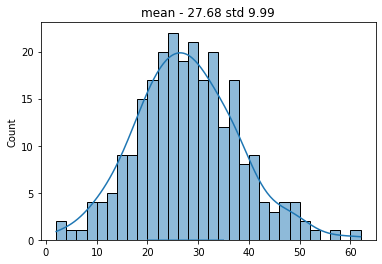

In [21]:
points_df = pd.read_csv('curry_reg_season_scoring.csv')
points = points_df['Points'].values

ax = sns.histplot(points, kde=True, bins=30)
_, bins, _ = plt.hist(points, 20, density=1, alpha=0.5)
mu, sigma = norm.fit(points)
plt.title('mean - {:.2f} std {:.2f}'.format(mu, sigma))
plt.show()

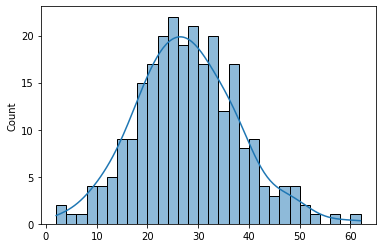

my 27.682539682539684 sigma 9.987016010205842


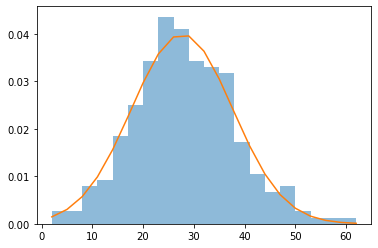

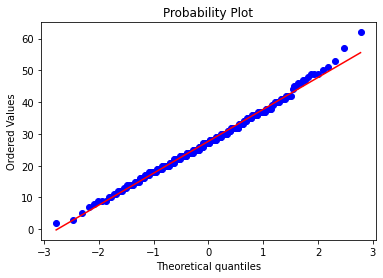

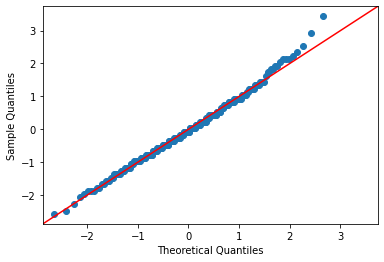

In [16]:
plot_dists('curry_reg_season_scoring.csv')

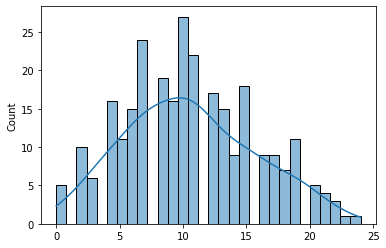

my 10.525 sigma 5.161611390143309


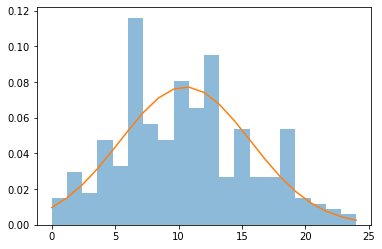

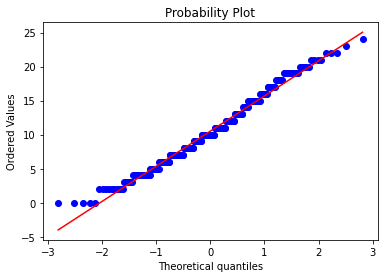

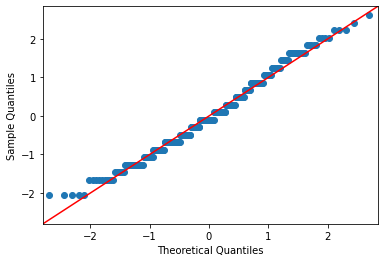

In [17]:
plot_dists('morris_reg_season_scoring.csv')

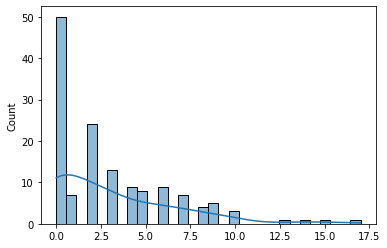

my 3.06993006993007 sigma 3.4714627812009784


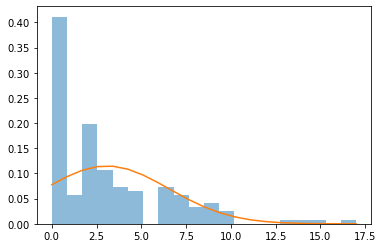

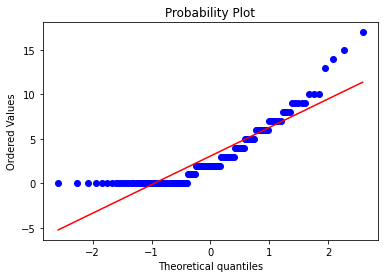

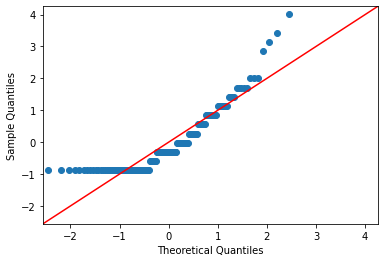

In [18]:
plot_dists('bonga_reg_season_scoring.csv')

For all 3 players, the scoring output can be approximated by a Gaussian distribution.
We approximate $\mu$ as the player scoring average and $\sigma$ as a function of the scoring average, approximated by a linear regression using the values found in the 3 exemplary players studied before. A chart illustrating this dependency can be found below.

In [19]:
points = [27.68,10.525,3.07]
stds = [9.98,5.16, 3.47]
x_points = np.array(points).reshape(-1, 1)
y_points = np.array(stds)

reg = LinearRegression().fit(x_points, y_points)
reg.score(x_points, y_points)
reg.coef_
reg.intercept_
reg.predict(np.array([[1]]))

array([2.79188505])

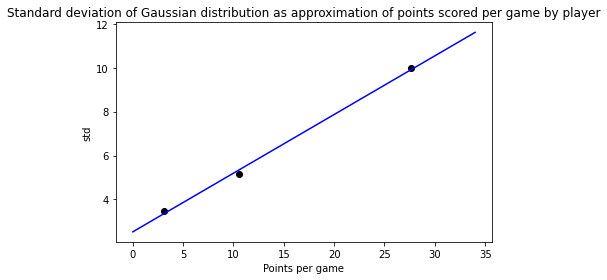

Mean squared error: 0.02


In [20]:
fig,ax = plt.subplots()
points_axis = list(range(35))
std = [reg.predict(np.array([[i]])) for i in points_axis]
plt.plot(points_axis, std,'b')
plt.title('Standard deviation of Gaussian distribution as approximation of points scored per game by player')
plt.ylabel('std')
plt.xlabel('Points per game')
plt.scatter(x_points, y_points, color='black')
plt.tight_layout()
plt.show()

print("Mean squared error: %.2f" % mean_squared_error(stds, [float(reg.predict(np.array([[i]]))) for i in points]))

### Plotting all means

In [79]:
category_col = 'player'
points_df_curry = pd.read_csv('curry_reg_season_scoring.csv')
points_df_curry[category_col] = 'curry'
points_df_morris = pd.read_csv('morris_reg_season_scoring.csv')
points_df_morris[category_col] = 'morris'
points_df_bonga = pd.read_csv('bonga_reg_season_scoring.csv')
points_df_bonga[category_col] = 'bonga'

df = pd.DataFrame()
df = df.append(points_df_curry[[category_col,'Points']])
df = df.append(points_df_morris[[category_col,'Points']])
df = df.append(points_df_bonga[[category_col,'Points']])


C:\Users\gabri\AppData\Local\Temp\ipykernel_11228\1227238796.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(points_df_curry[[category_col,'Points']])
C:\Users\gabri\AppData\Local\Temp\ipykernel_11228\1227238796.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(points_df_morris[[category_col,'Points']])
C:\Users\gabri\AppData\Local\Temp\ipykernel_11228\1227238796.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(points_df_bonga[[category_col,'Points']])


In [63]:
#sns.displot(df, x="Points", hue="cat", stat="kde")

C:\Users\gabri\miniconda3\envs\nba-franchise-manager\lib\site-packages\seaborn\distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


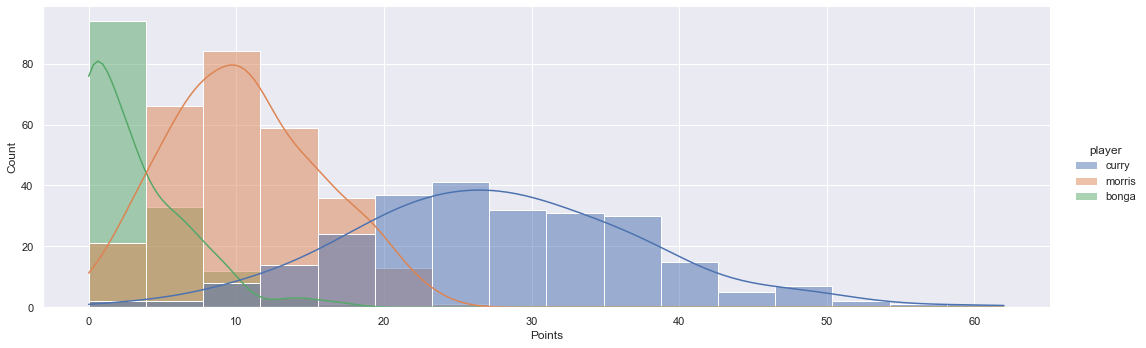

In [97]:
sns.set(rc={"figure.figsize":(16, 9)}) #width=8, height=4
distplot = sns.displot(df.reset_index(), x="Points", kind="hist", hue=category_col, kde=True, ax=ax,
           height=5, aspect=3)

In [92]:
distplot.fig.savefig("hists_players_scoring_avg.png") 

In [93]:
df.describe()

,Points
count,675.000000
mean,15.351111
std,12.224883
min,0.000000
25%,6.000000
50%,12.000000
75%,23.000000
max,62.000000


In [94]:
# qqplot

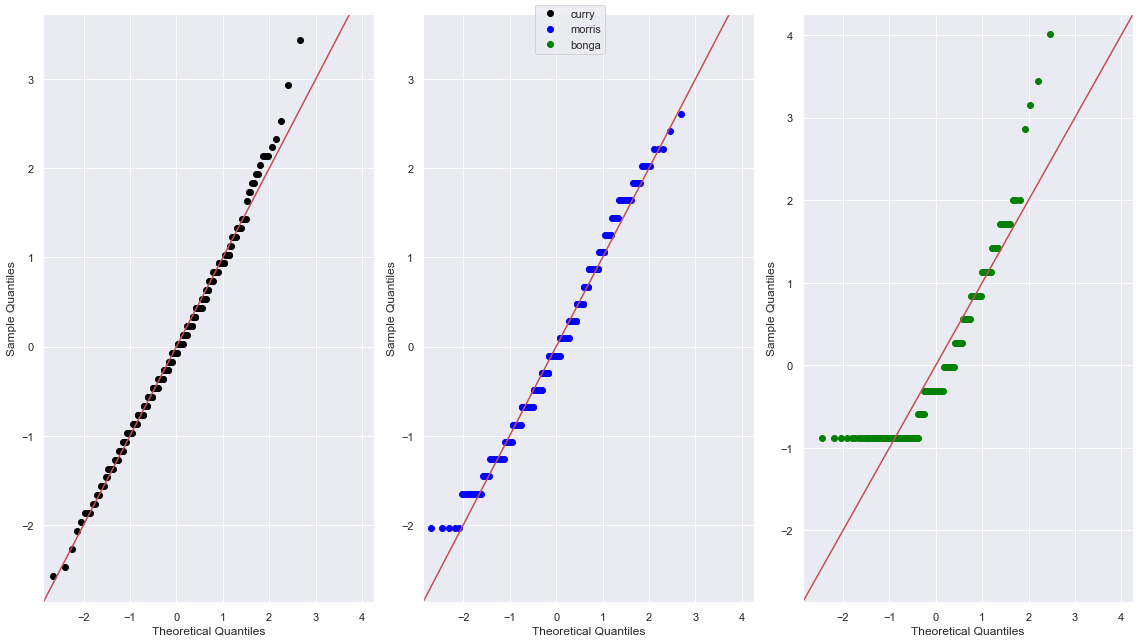

In [145]:
fig,ax = plt.subplots(ncols=3, sharex=True, figsize=(16,9))
#sm.qqplot(df[df.player=='curry'].Points.values,fit=True, line="q", label='curry', ax=ax)
color1='black'
color2='blue'
color3='green'
sm.qqplot(df[df.player=='curry'].Points.values,fit=True, line="45", label='curry', ax=ax[0], 
          markerfacecolor=color1, markeredgecolor=color1)
sm.qqplot(df[df.player=='morris'].Points.values,fit=True, line="45", label='morris', ax=ax[1], 
          markerfacecolor=color2, markeredgecolor=color2)
sm.qqplot(df[df.player=='bonga'].Points.values,fit=True, line="45", label='bonga', ax=ax[2], 
          markerfacecolor=color3, markeredgecolor=color3)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center')

plt.tight_layout()
#plt.show()
plt.savefig("qqplot_players.png")